# Bagging and Boosting over Decision Trees

### Outline <a name = 'outline'></a>
* [Data generation](#data) 
* [Decision tree](#tree) 
* [Random forest](#rf)
* [Gradient Boosting](#gb)

In [107]:
import warnings
warnings.filterwarnings('ignore')

In [108]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn import tree, ensemble, model_selection

from matplotlib import pyplot as plt
matplotlib.pyplot.style.use('ggplot')

In [109]:
%matplotlib inline

## Data <a name = 'data'></a>

Problem statement at kaggle: https://www.kaggle.com/c/bioresponse

Data: https://www.kaggle.com/c/bioresponse/data we use train.csv

Based on a given characteristics of the molecule, it is required to determine whether a biological response will be given

Features are normalised

In [110]:
bioresponse = pd.read_csv('bioresponse.csv', header=0, sep=',')

In [111]:
bioresponse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


In [112]:
bioresponse.head()

Activity        D1        D2    D3   D4        D5        D6        D7  \
0         1  0.000000  0.497009  0.10  0.0  0.132956  0.678031  0.273166   
1         1  0.366667  0.606291  0.05  0.0  0.111209  0.803455  0.106105   
2         1  0.033300  0.480124  0.00  0.0  0.209791  0.610350  0.356453   
3         1  0.000000  0.538825  0.00  0.5  0.196344  0.724230  0.235606   
4         0  0.100000  0.517794  0.00  0.0  0.494734  0.781422  0.154361   

         D8        D9  ...  D1767  D1768  D1769  D1770  D1771  D1772  D1773  \
0  0.585445  0.743663  ...      0      0      0      0      0      0      0   
1  0.411754  0.836582  ...      1      1      1      1      0      1      0   
2  0.517720  0.679051  ...      0      0      0      0      0      0      0   
3  0.288764  0.805110  ...      0      0      0      0      0      0      0   
4  0.303809  0.812646  ...      0      0      0      0      0      0      0   

   D1774  D1775  D1776  
0      0      0      0  
1      0      1      0  
2      0      0      0  
3      0      0      0  
4      0      0      0  

[5 rows x 1777 columns]

In [113]:
bioresponse_data.describe()

D1           D2           D3           D4           D5  \
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000   
mean      0.076948     0.592436     0.068142     0.038990     0.212112   
std       0.079989     0.105860     0.078414     0.115885     0.102592   
min       0.000000     0.282128     0.000000     0.000000     0.002630   
25%       0.033300     0.517811     0.000000     0.000000     0.138118   
50%       0.066700     0.585989     0.050000     0.000000     0.190926   
75%       0.100000     0.668395     0.100000     0.000000     0.261726   
max       1.000000     0.964381     0.950000     1.000000     1.000000   

                D6           D7           D8           D9          D10  ...  \
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000  ...   
mean      0.686653     0.274713     0.455133     0.749517     0.270411  ...   
std       0.078702     0.090017     0.162731     0.071702     0.096128  ...   
min       0.137873     0.006130     0.000000     0.275590     0.003040  ...   
25%       0.625627     0.207374     0.378062     0.707339     0.194357  ...   
50%       0.674037     0.277845     0.499942     0.738961     0.284316  ...   
75%       0.740663     0.335816     0.569962     0.788177     0.344626  ...   
max       0.994735     0.790831     0.989870     1.000000     1.000000  ...   

             D1767        D1768        D1769        D1770        D1771  \
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000   
mean      0.026926     0.014663     0.013863     0.021861     0.015196   
std       0.161889     0.120215     0.116938     0.146249     0.122348   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             D1772        D1773        D1774        D1775        D1776  
count  3751.000000  3751.000000  3751.000000  3751.000000  3751.000000  
mean      0.016796     0.012263     0.011730     0.020261     0.011197  
std       0.128522     0.110074     0.107683     0.140911     0.105236  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 1776 columns]

In [114]:
bioresponse.Activity.value_counts()

1    2034
0    1717
Name: Activity, dtype: int64

In [115]:
bioresponse_target = bioresponse.Activity.values

In [116]:
bioresponse_data = bioresponse.iloc[:, 1:]

[back to outline](#outline)

## Decision tree classifier <a name = 'tree'></a>

In [120]:
tree_model = tree.DecisionTreeClassifier(min_samples_split = 10)

In [121]:
tree_scoring = model_selection.cross_val_score(tree_model, 
                                                bioresponse_data, 
                                                bioresponse_target, 
                                                scoring = 'accuracy', 
                                                cv = 5)

In [122]:
np.mean(tree_scoring)

0.7243367766579732

[back to outline](#outline)

## Random forest <a name = 'rf'></a>

In [126]:
?ensemble.RandomForestClassifier

In [130]:
rf_model = ensemble.RandomForestClassifier(n_estimators = 10, min_samples_split = 10, 
                                           n_jobs = -1, random_state = 1)

In [131]:
rf_scoring = model_selection.cross_val_score(rf_model,
                                             bioresponse_data, 
                                             bioresponse_target,
                                             scoring = 'accuracy',
                                             cv = 5)

In [132]:
np.mean(rf_scoring)

0.7611368107913673

### How many trees do we need? 

In [138]:
n_trees = [1] + list(range(10, 75, 5))

In [139]:
n_trees

[1, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

In [144]:
rf_scoring = []
for n_tree in n_trees:
    model = ensemble.RandomForestClassifier(n_estimators = n_tree, 
                                            min_samples_split = 10, 
                                            random_state = 1)
    
    score = model_selection.cross_val_score(model,
                                            bioresponse_data,
                                            bioresponse_target,
                                            scoring = 'accuracy',
                                            cv = 3)
    
    rf_scoring.append(score)
    
rf_scoring = np.asmatrix(rf_scoring)

In [142]:
rf_scoring = np.asmatrix(rf_scoring)

matrix([[0.66666667, 0.6352    , 0.6528    ],
        [0.74260592, 0.756     , 0.7664    ],
        [0.745004  , 0.764     , 0.7712    ],
        [0.7490008 , 0.7736    , 0.776     ],
        [0.76099121, 0.7744    , 0.7808    ],
        [0.76179057, 0.7776    , 0.7848    ],
        [0.76179057, 0.776     , 0.7824    ],
        [0.77298161, 0.7744    , 0.7896    ],
        [0.77378098, 0.7776    , 0.7912    ],
        [0.77458034, 0.7784    , 0.7936    ]])

In [147]:
np.max(rf_scoring.mean(axis = 1))

0.7869915267785772

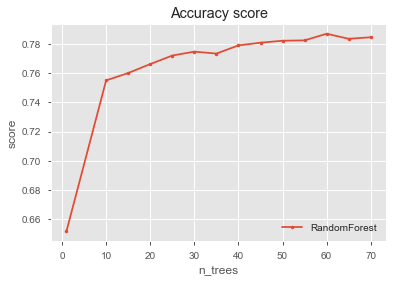

In [145]:
plt.plot(n_trees, rf_scoring.mean(axis = 1), marker='.', label='RandomForest')
plt.xlabel('n_trees')
plt.ylabel('score')
plt.title('Accuracy score')
plt.legend(loc = 'lower right')

### Do we have enough data to train model? 
**Learning curves**

In [148]:
train_sizes, train_scores, test_scores = model_selection.learning_curve(rf_model, 
                                                                        bioresponse_data, 
                                                                        bioresponse_target,
                                                                        train_sizes = np.arange(0.1,1., 0.2),
                                                                        cv = 3, 
                                                                        scoring = 'accuracy')

In [149]:
print(train_sizes)
print(train_scores.mean(axis = 1))
print(test_scores.mean(axis = 1))

[ 250  750 1250 1750 2250]
[0.98533333 0.98888889 0.99146667 0.98990476 0.99081481]
[0.6624874  0.7187417  0.73687248 0.7453992  0.75819771]


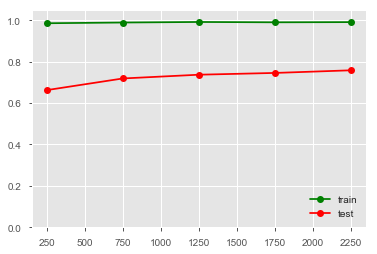

In [150]:
plt.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
plt.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
plt.ylim((0.0, 1.05))
plt.legend(loc='lower right')

[back to outline](#outline)

## Gradient Boosting <a name = 'gb'></a>

In [154]:
xgb_model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 50) 

In [155]:
xgb_scoring = model_selection.cross_val_score(xgb_model,
                                             bioresponse_data, 
                                             bioresponse_target,
                                             scoring = 'accuracy',
                                             cv = 3)

In [156]:
np.mean(xgb_scoring)

0.7861883293365307

### Again, how many trees do we need? 

In [164]:
n_trees = [1] + list(range(10, 75, 5))

In [166]:
%%time
xgb_scoring = []
for n_tree in n_trees:
    model = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = n_tree,
                             min_child_weight = 3)
    
    score = model_selection.cross_val_score(model, bioresponse_data, bioresponse_target,
                                             scoring = 'accuracy', cv = 3)    
    xgb_scoring.append(score)
    
xgb_scoring = np.asmatrix(xgb_scoring)

CPU times: user 14min 9s, sys: 15.9 s, total: 14min 25s
Wall time: 16min 14s


In [167]:
xgb_scoring

matrix([[0.76498801, 0.756     , 0.756     ],
        [0.77617906, 0.7752    , 0.7688    ],
        [0.77857714, 0.7744    , 0.7768    ],
        [0.7873701 , 0.7784    , 0.7768    ],
        [0.79216627, 0.7736    , 0.7832    ],
        [0.79776179, 0.7776    , 0.7824    ],
        [0.79616307, 0.7816    , 0.78      ],
        [0.79296563, 0.7848    , 0.7792    ],
        [0.79856115, 0.7832    , 0.7808    ],
        [0.79936051, 0.7832    , 0.7832    ],
        [0.79776179, 0.7832    , 0.7856    ],
        [0.80095923, 0.7824    , 0.7864    ],
        [0.79936051, 0.7824    , 0.7888    ],
        [0.79776179, 0.7816    , 0.7896    ]])

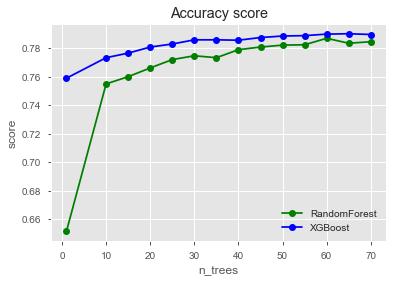

In [169]:
plt.plot(n_trees, rf_scoring.mean(axis = 1), 'g-', marker = 'o', label = 'RandomForest')
plt.plot(n_trees, xgb_scoring.mean(axis = 1), 'b-', marker='o', label = 'XGBoost')
plt.xlabel('n_trees')
plt.ylabel('score')
plt.title('Accuracy score')
plt.legend(loc = 'lower right')

[back to outline](#outline)